In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install skforecast

## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent. However, we want to predict all variables therefore therefore, we are going build a model that can handle parallel multiseries data

> Parallel multiseries forcasting can be:
 * ***Dependent*** multi-series => using *ForecasterAutoregMultiSeries* and *ForecasterAutoregMultiSeriesCustom* classes
 * ***Independent*** multiseries => using  *ForecasterAutoregMultiVariate* class

## Independent

In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df_downsampled = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_MODISData.csv')
df_downsampled = df_downsampled[['date','ndvi','evi','ndwi']]
df_downsampled.head()

,date,ndvi,evi,ndwi
0,2000-03-23,0.194392,0.131728,-0.066057
1,2000-03-30,0.188009,0.121651,-0.059209
2,2000-04-06,0.180129,0.124651,-0.051936
3,2000-04-13,0.167050,0.131804,-0.032578
4,2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Data preparation
data = df_downsampled
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,ndvi,evi,ndwi
date,,,
2000-03-23,0.194392,0.131728,-0.066057
2000-03-30,0.188009,0.121651,-0.059209
2000-04-06,0.180129,0.124651,-0.051936
2000-04-13,0.167050,0.131804,-0.032578
2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2000-03-23 00:00:00 --- 2019-12-26 00:00:00   (n=1032)
Test dates  : 2020-01-02 00:00:00 --- 2023-02-16 00:00:00   (n=164)


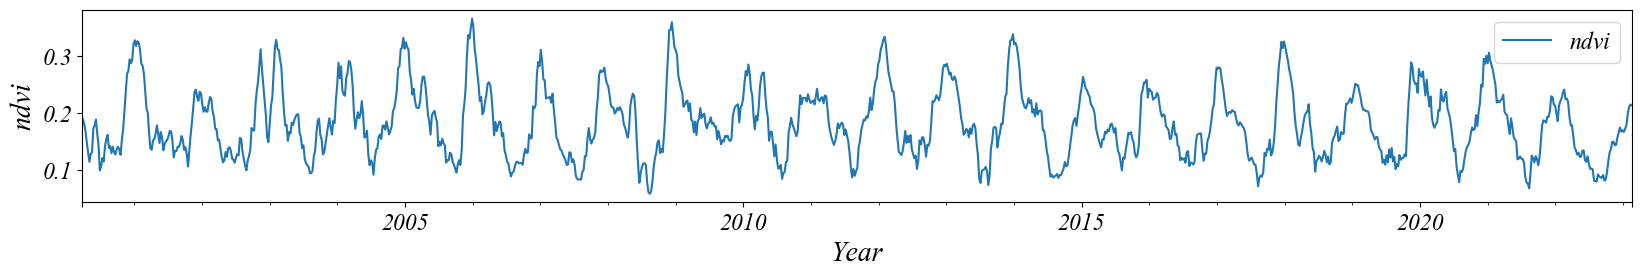

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
# Plot
# ==============================================================================
font1 = {'family':'Times New Roman','color':'blue','size':20}
font2 = {'family':'Times New Roman','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data['ndvi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

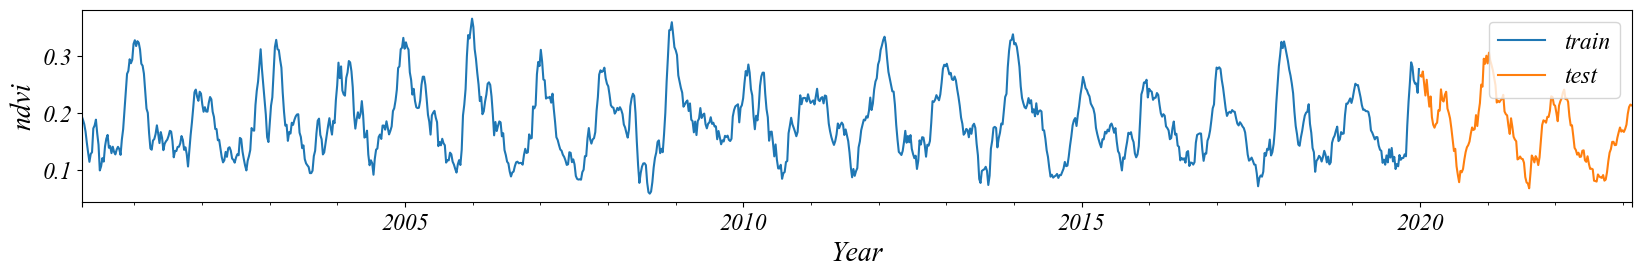

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

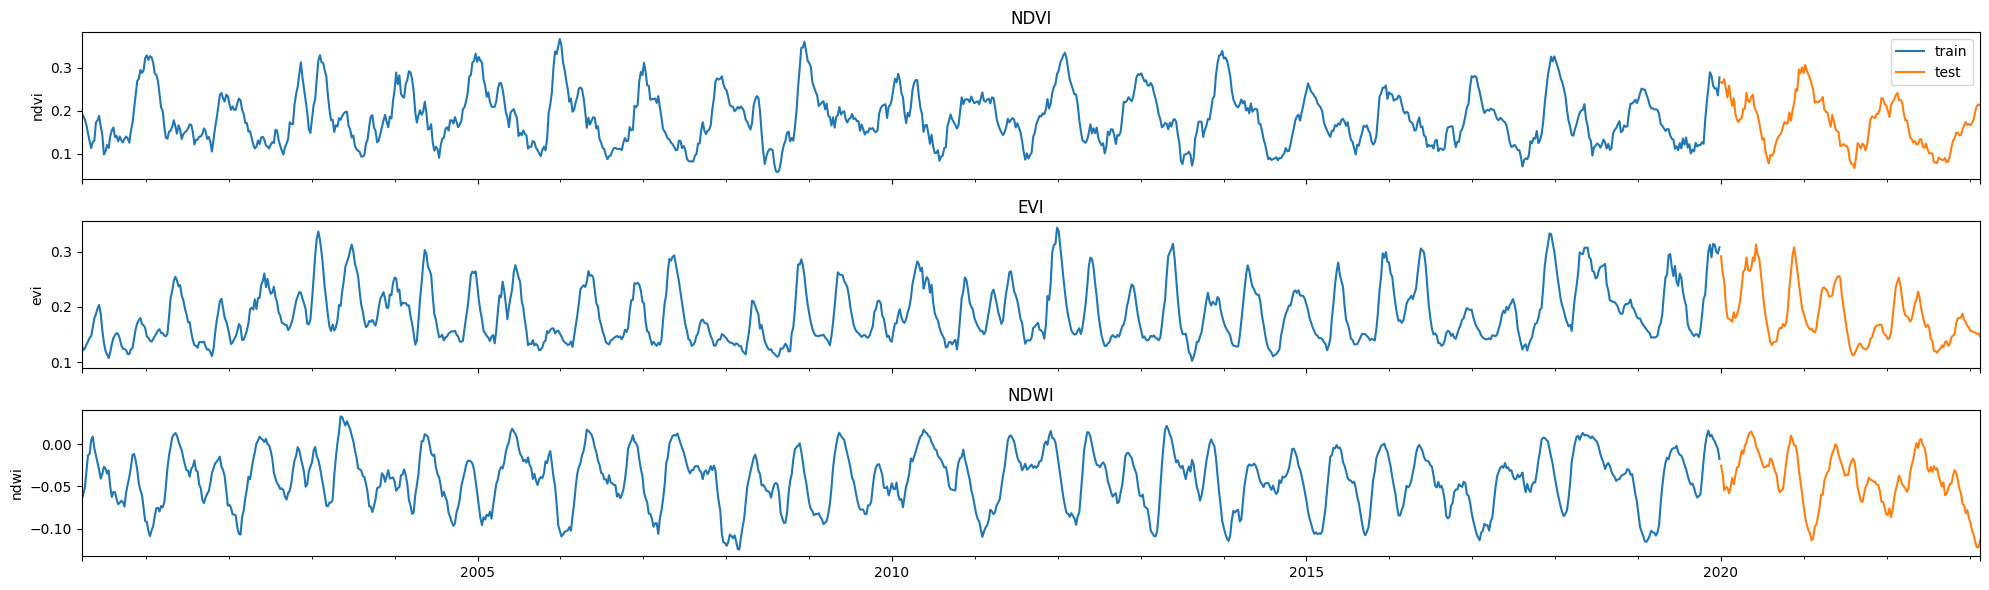

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 6), sharex=True)

data_train['ndvi'].plot(label='train', ax=axes[0])
data_test['ndvi'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('ndvi')
axes[0].set_title('NDVI')
axes[0].legend()

data_train['evi'].plot(label='train', ax=axes[1])
data_test['evi'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('evi')
axes[1].set_title('EVI')

data_train['ndwi'].plot(label='train', ax=axes[2])
data_test['ndwi'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('ndwi')
axes[2].set_title('NDWI')

fig.tight_layout()
plt.show();

### LGB

> Single Step

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(),
                 lags               = 20,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

In [ ]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [10, 20, 50, 100]
param_grid = {
    'n_estimators': [50, 100,200],
    'max_depth': [5, 10, 15]
}
levels = ['ndvi', 'evi', 'ndwi']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 1,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )

results

36 models compared for 3 level(s). Number of iterations: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,max_depth,n_estimators
18,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",0.008631,5,50
0,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.008685,5,50
19,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.008698,5,100
1,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.008736,5,100
24,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 50}",0.008770,15,50
6,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.008783,15,50
3,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.008790,10,50
7,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.008806,15,100
4,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.008837,10,100
20,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.008839,5,200


In [ ]:
print(results.lags[18])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(max_depth= 5, n_estimators=50),
                 lags               = 50,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )
forecaster.fit(data)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12756
[LightGBM] [Info] Number of data points in the train set: 3438, number of used features: 53
[LightGBM] [Info] Start training from score 0.012891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [ ]:
# Backtesting Multi Series
# ==============================================================================
levels = ['ndvi', 'evi', 'ndwi']
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           levels                = levels,
                                           steps                 = 1,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12756
[LightGBM] [Info] Number of data points in the train set: 2946, number of used features: 53
[LightGBM] [Info] Start training from score 0.015485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

  0%|          | 0/164 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,ndvi,0.011766,0.000218,0.076553
1,evi,0.008414,0.000117,0.044699
2,ndwi,0.005649,0.000047,0.497818



Backtest predictions


,ndvi,evi,ndwi
2020-01-02,0.271136,0.301023,-0.027862
2020-01-09,0.265138,0.289300,-0.032636
2020-01-16,0.253306,0.246257,-0.045410
2020-01-23,0.263971,0.226705,-0.061664


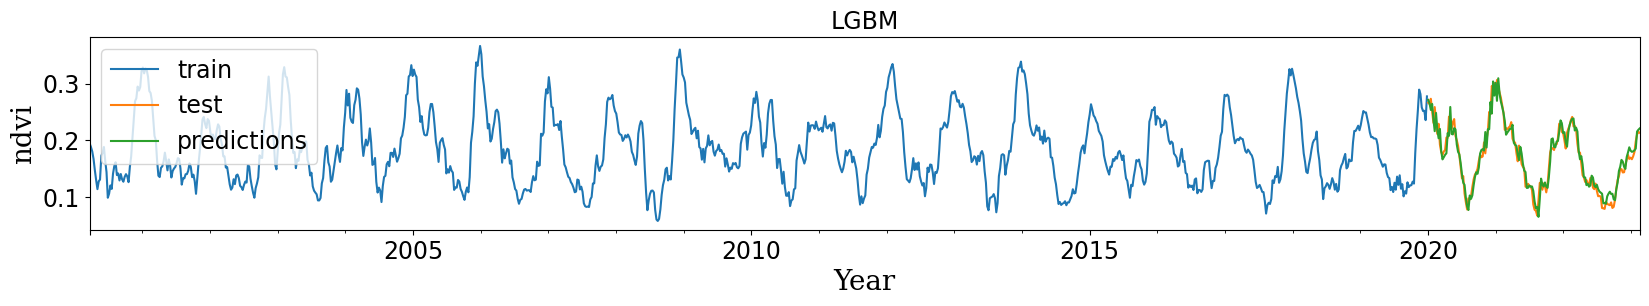

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
backtest_predictions['ndvi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='LGBM')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

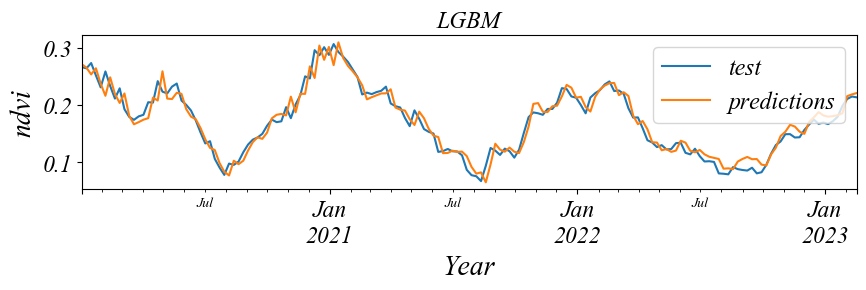

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['ndvi'].plot(ax=ax, label='test')
backtest_predictions['ndvi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='LGBM')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

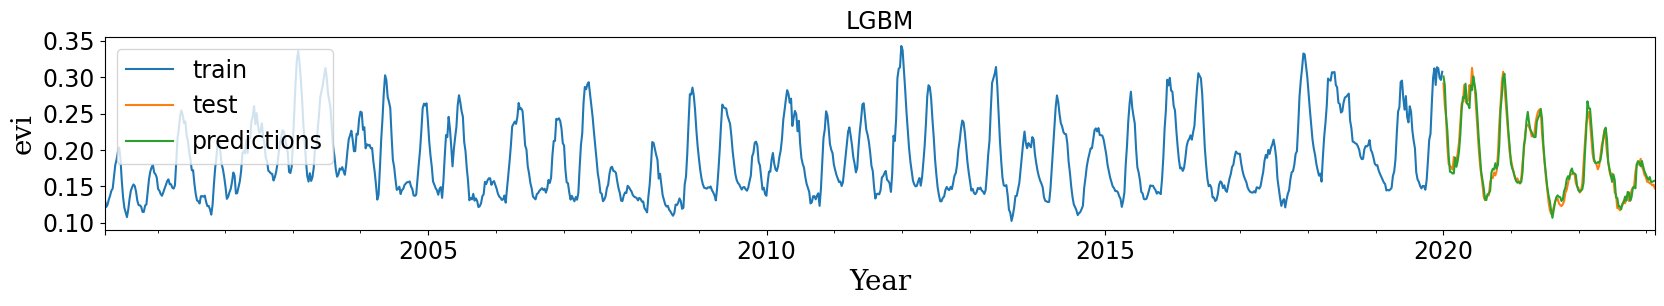

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['evi'].plot(ax=ax, label='train')
data_test['evi'].plot(ax=ax, label='test')
backtest_predictions['evi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='LGBM')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("evi",fontdict = font2)
ax.legend(fontsize=17);

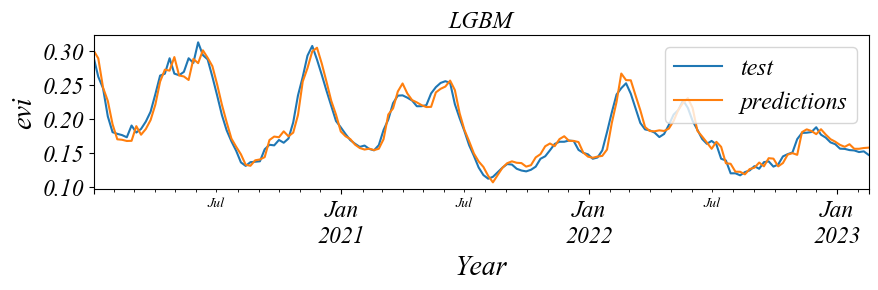

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['evi'].plot(ax=ax, label='test')
backtest_predictions['evi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='LGBM')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("evi",fontdict = font2)
ax.legend(fontsize=17);

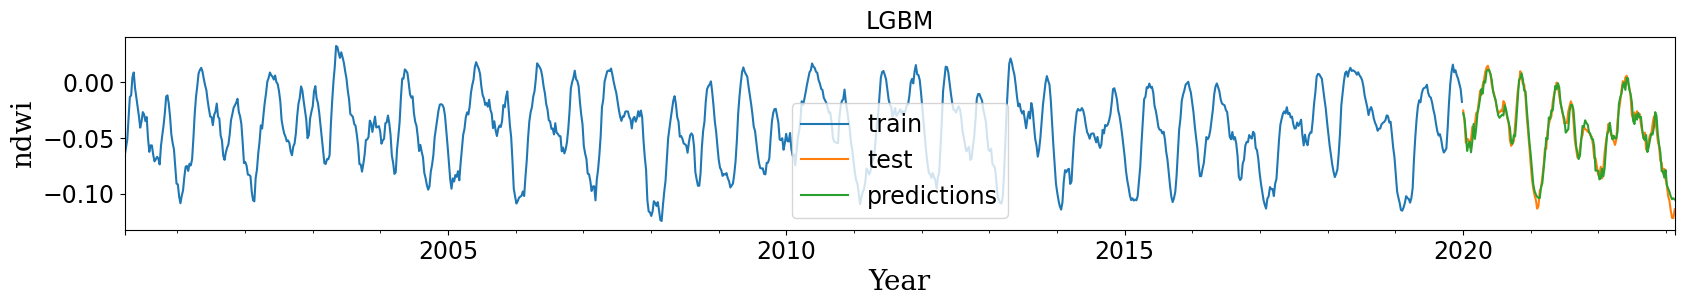

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndwi'].plot(ax=ax, label='train')
data_test['ndwi'].plot(ax=ax, label='test')
backtest_predictions['ndwi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='LGBM')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndwi",fontdict = font2)
ax.legend(fontsize=17);

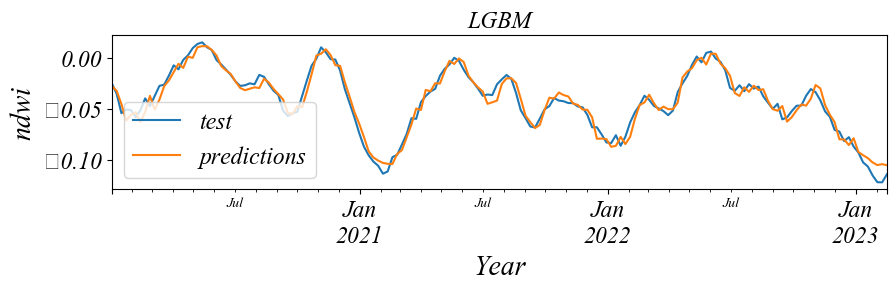

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['ndwi'].plot(ax=ax, label='test')
backtest_predictions['ndwi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='LGBM')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndwi",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['ndvi'],backtest_predictions['ndvi'])
mse = mean_squared_error(data_test['ndvi'],backtest_predictions['ndvi'])
r2 = r2_score(data_test['ndvi'],backtest_predictions['ndvi'])
rmse = math.sqrt(mean_squared_error(data_test['ndvi'],backtest_predictions['ndvi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.011766258671647082
MSE is 0.00021846744810072533
RMSE is 0.014780644373664002
R2 is 0.9340024768228194


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['evi'],backtest_predictions['evi'])
mse = mean_squared_error(data_test['evi'],backtest_predictions['evi'])
r2 = r2_score(data_test['evi'],backtest_predictions['evi'])
rmse = math.sqrt(mean_squared_error(data_test['evi'],backtest_predictions['evi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.008414226257563929
MSE is 0.00011738385428252715
RMSE is 0.010834382967318774
R2 is 0.9507204871948016


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['ndwi'],backtest_predictions['ndwi'])
mse = mean_squared_error(data_test['ndwi'],backtest_predictions['ndwi'])
r2 = r2_score(data_test['ndwi'],backtest_predictions['ndwi'])
rmse = math.sqrt(mean_squared_error(data_test['ndwi'],backtest_predictions['ndwi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.005648573500048818
MSE is 4.6881087513915454e-05
RMSE is 0.0068469765235405515
R2 is 0.9507014692990191


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,backtest_predictions)
mse = mean_squared_error(data_test,backtest_predictions)
r2 = r2_score(data_test,backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test,backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.00860968614308661
MSE is 0.00012757746329905597
RMSE is 0.011295019402331984
R2 is 0.9451414777722134


In [ ]:
forecaster.fit(data)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12756
[LightGBM] [Info] Number of data points in the train set: 3438, number of used features: 53
[LightGBM] [Info] Start training from score 0.012891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [ ]:
future_prediction=forecaster.predict(steps=300)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [ ]:
future_prediction

,ndvi,evi,ndwi
2023-02-23,0.209496,0.147035,-0.109495
2023-03-02,0.205470,0.146374,-0.107162
2023-03-09,0.201136,0.146843,-0.102241
2023-03-16,0.193260,0.146096,-0.091429
2023-03-23,0.179519,0.147038,-0.082771
...,...,...,...
2028-10-19,0.119743,0.172314,-0.056376
2028-10-26,0.117228,0.172152,-0.053035
2028-11-02,0.117208,0.173279,-0.050061
2028-11-09,0.116630,0.176528,-0.049580


Text(0, 0.5, 'NDVI')

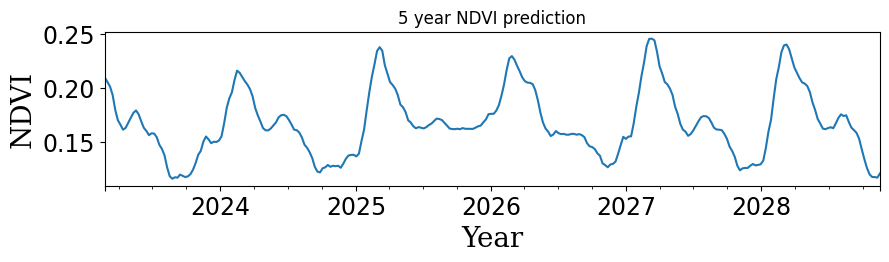

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['ndvi'].plot(ax=ax, label='ndvi',title='5 year NDVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDVI",fontdict = font2)

Text(0, 0.5, 'EVI')

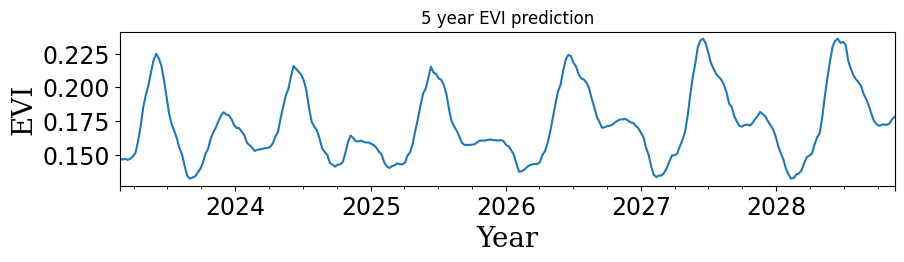

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['evi'].plot(ax=ax, label='evi',title='5 year EVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("EVI",fontdict = font2)

Text(0, 0.5, 'NDWI')

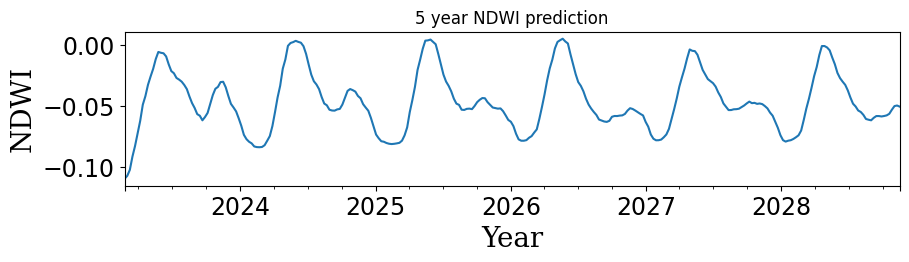

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['ndwi'].plot(ax=ax, label='ndwi',title='5 year NDWI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDWI",fontdict = font2)